# Intro
For the purposes of this project, we are considering a stock to be an example of a *chaotic system*, in which we hope to model and predict it with the aid of discretized differential equations. 

We can query online stock APIs for 2-year daily historical price data. This is the only initial data that we need for the program. 

This means that we start with data for $p(t)$ for a specific set of points, and we want to find $p(t + 1), p(t + 2) ...$

Let a stock's particular price on a certain day be its ***position***. Then we can start our model off of basic kinematic equations from physics:

$x = x_0 + v_0t + \frac{1}{2}at^2$

$x = x_0 + \hat{v}t$

$v = v_0 + at$

But recall that:

$\frac{dx}{dt} = v, \frac{dv}{dt} = a, \frac{d^2x}{dt^2} = a$

Now, instead of $x$, let us use $p(t),$ and replace let $v = p'(t)$, $a = p''(t)$, and redefine $t = h$:

$p(t + 1) = p(t) + hp'(t) + \frac{h^2}{2}p''(t)$

PROBLEM! We can't solve for p'(t), p''(t). There is not underlying analytical function to differentiate. What can we do? 

**> Use a Discrete Method**. There are a couple different formulas, but since we are trying to predict the *next* day, we want to use a backwards difference method. This is something we struggled with and Dr. Pasteur assisted us in finding these online. Since our current approach goes up to the second derivative, we need to use (at least) 3 points for the second derivative. If possible, we should use the same number of points for calculating each derivative. So:

$p(t) = p(t)$ (trivial)

$p'(t) = \frac{3p(t) - 4p(t - 1) + p(t - 2)}{2h}$

$p''(t) = \frac{p(t) - 2p(t - 1) + p(t - 2)}{h^2}$

Now we have defined $p'(t), p''(t)$ in terms of discrete points of $p(t)$. Now we have enough to try a stock prediction... (lets convert some of this ideology to python code)

Average difference in prediction and actual value: 0.004019999999999414


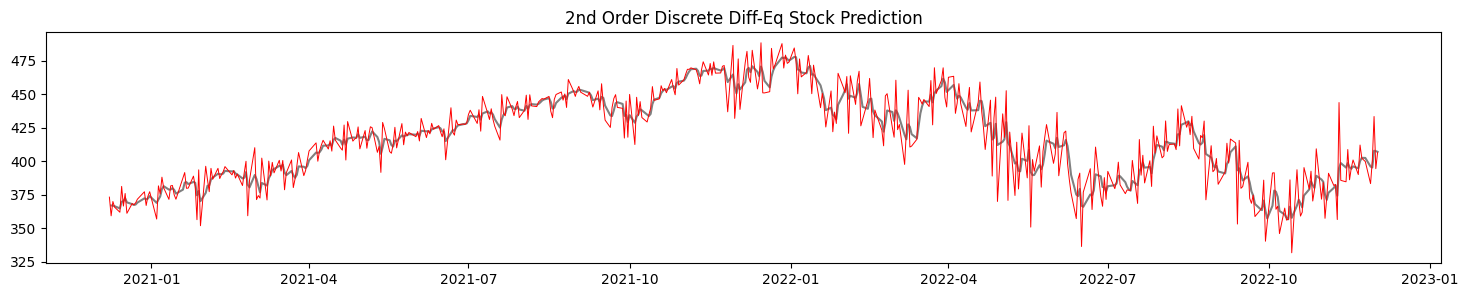

In [19]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

# read in dataset
ticker="SPY"
df = pd.read_csv(f"{ticker}HistoricalData.csv")

# read in discrete points for p(t)
prices = np.array(df["c"])

# sizing figure
plt.rcParams["figure.figsize"] = (18, 3)

# grab timestamps to graph on
timestamps = pd.to_datetime(df["day"])

# returns 3 x N matrix. in each row, the first entry is position, second is velocity, third is acceleration
def accel_predict(price_points):
    soln = []
    for step in range(2, prices.size):
        xi, xi_1, xi_2 = price_points[step], price_points[step-1], price_points[step-2]
        # our price at a certain point... is just the price at a certain point (😁)
        p_x = xi
        # 3 point backwards first derivative finite difference
        v_x = (3 * xi - 4 * xi_1 + xi_2) / 2
        # 4 point backward second derivative finite difference 
        a_x = (xi) - (2 * xi_1) + (xi_2)
       

        step_vec = np.array([p_x, v_x, a_x])
        soln.append(step_vec)
    return soln

def next_price(inputs):
    return inputs[0] + inputs[1] + (1/2)*inputs[2]

finite_points = accel_predict(prices)

day = 2
one_step_guesses = []
for row in finite_points:
    #print("(Actual) Day",day,row[0])
    guess = np.round(next_price(row), 3)
    #print("(Prediction) Day",day+1,guess)
    one_step_guesses.append(guess)
    day += 1

#print(np.array([x - y for x, y in zip(one_step_guesses, price_compare)]))
price_compare = prices[3:] # predictions start on day 2 going to day 3 :)
#print(price_compare[:10],one_step_guesses[:10])
plt.plot(timestamps[3:], price_compare, color="gray", label="actual")
plt.plot(timestamps[2:], one_step_guesses, color="red", label="predicted", linewidth=0.7)
plt.title("2nd Order Discrete Diff-Eq Stock Prediction")
diffs = np.array([x - y for x, y in zip(one_step_guesses, price_compare)])
print("Average difference in prediction and actual value:",np.average(diffs))


# Jerk

Now, what if we wanted to add additional parameters to the equation?

When trying to model a chaotic system, we may benefit from tracking and equating the *jerk*:

$j = \frac{d^3x}{dt^3} = \frac{d^2v}{dt^2} = \frac{da}{dt}$

For us, this is $p'''(t)$, the third derivative of price position.

Additionally, now we want 4 points in our backwards discrete difference formulas. Converting these changes to code...

Average difference in prediction and actual value: -0.027969939879760302


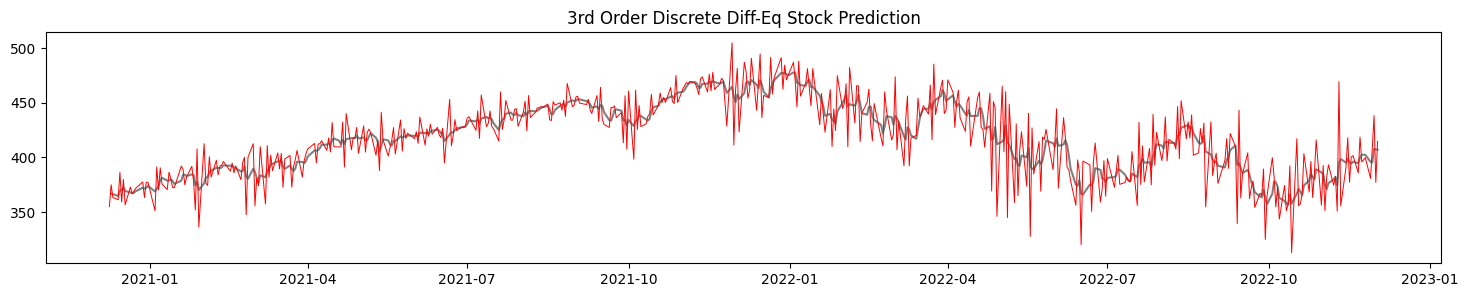

In [28]:
def jerk_predict(price_points):
    soln = []
    for step in range(3, prices.size):
        xi, xi_1, xi_2, xi_3 = price_points[step], price_points[step-1], price_points[step-2], price_points[step-3]
        # our price at a certain point... is just the price at a certain point (😁)
        p_x = xi
        # 4 point backward first derivative finite difference
        # difficulty finding this one... using a 3 point one for now as bandaid
        v_x = (3 * xi - 4 * xi_1 + xi_2) / 2
        # 4 point backward second derivative finite difference 
        a_x = (2 * xi) - (5 * xi_1) + (4 * xi_2) - (xi_3)
        # 4 point backward third derivative finite difference
        j_x = xi - (3 * xi_1) + (3 * xi_2) - (1 * xi_3)

        step_vec = np.array([p_x, v_x, a_x, j_x])
        soln.append(step_vec)
    return soln

def next_jerk_price(row):
    return row[0] + row[1] + (1/2)*row[2] + (1/6)*row[3]

jerk_points = jerk_predict(prices)
day = 3
one_step_guesses = []

for row in jerk_points:
    guess = np.round(next_jerk_price(row), 3)
    one_step_guesses.append(guess)
    day += 1

    #print("(Actual) Day",day,row[0])
    #print("(Prediction) Day",day+1,guess)

#print(np.array([x - y for x, y in zip(one_step_guesses, price_compare)]))
price_compare = prices[4:] # predictions start on day 2 going to day 3 :)
#print(price_compare[:10],one_step_guesses[:10])
plt.plot(timestamps[4:], price_compare, color="gray", label="actual")
plt.plot(timestamps[3:], one_step_guesses, color="red", label="predicted", linewidth=0.7)
plt.title("3rd Order Discrete Diff-Eq Stock Prediction")
diffs = np.array([x - y for x, y in zip(one_step_guesses, price_compare)])
print("Average difference in prediction and actual value:",np.average(diffs))